In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
train_d = pd.read_csv("./Data/train.csv")
train_label = pd.read_csv("./Data/train_label.csv")
train_d.head()

,ID,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,-6.305161,0,0,Check-Out,2015-07-01
1,1,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,75.052227,0,0,Check-Out,2015-07-03
2,2,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,74.546401,0,0,Check-Out,2015-07-03
3,3,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,76.376288,0,0,Check-Out,2015-07-03
4,4,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,49.411647,0,0,Check-Out,2015-07-03


In [ ]:
##整理有哪些Column, 以及每一個Column代表的特性
"""
ID: int/
hotel: str/ (Resort Hotel, City Hotel)
is_canceled: int/ Value indicating if the booking was canceled (1) or not (0)
lead_time: int/ 從下訂單到實際入住的時間差
arrival_date_year: int/ from 2015 to 2017
arrival_date_month: str
arrival_date_week_number: int/ 用整年52週，哪一週入住的時間來算
arrival_date_day_of_month: Day of arrival date
stays_in_weekend_nights: int/ Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel(從0~19)
stays_in_week_nights: int/ Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel(從0~50)
adults: int
children: int
babies: int
meal: str/ 5 different meal
country: str/ 163 different country
market_segment: str/ Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”: 8種
is_repeated_guest: int/ Value indicating if the booking name was from a repeated guest (1) or not (0)
previous_cancellations: int/ Number of previous bookings that were cancelled by the customer prior to the current booking
previous_bookings_not_canceled: int/ Number of previous bookings not cancelled by the customer prior to the current booking
reserved_room_type: str/ Code of room type reserved. Code is presented instead of designation for anonymity reasons. (10種)
assigned_room_type: str/ Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.(12種)
booking_changes: int/ Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
deposit_type:str/ Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.(3種)
agent:int/ ID of the travel agency that made the booking(301種)
company:int/ ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons(328種)
days_in_waiting_list:int/ Number of days the booking was in the waiting list before it was confirmed to the customer
customer_type:str/ Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking(4種)
adr:float/ Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
required_car_parking_spaces:int/ Number of car parking spaces required by the customer
total_of_special_requests:int/ Number of special requests made by the customer (e.g. twin bed or high floor)
reservation_status:str/ Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why(3種)
reservation_status_date: date/ Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel
"""

#previous_cancellation與not canceled或許可以合併成新欄位
#reserved_room_type 與 assigned_room_type可能不同, 可能因為現場要求換房或overbooking
#adr是average daily revenue 相當重要！
#reservation status date可以搭配reservation_status, 算出他是否有cancel, 也能藉此算出這個旅客待多久(可以算出Profit)
#agent是ID, 暫且不做處理, 直接drop
#testing data沒有以下column: is_canceled, adr, reservation_status, reservation_status_date

#助教在Cool上面的解釋：
#For simplicity, we don't consider refunding while calculating the revenue.
#ADR is the average price per day. You don't need to consider the number of people while calculating revenue.
#其中一種做法：先predict出revenue, 再按照revenue去做quantization

#比較重要的factor
#lead time

#一些想法：
#可以改目標，去預測adr，然後在testing data上乘上week+weekend day就可以是total profit了 //這是不是比較簡單？
#額外預測cancel的話, 也可以根據之前的previous cancel, days in waiting list等等預測, (但會缺少很多data)

## Data Cleaning

In [3]:
def strTodatetime(datestr, format):
    return datetime.datetime.strptime(datestr, format)

In [4]:
train_d = pd.read_csv("./Data/train.csv")
train_label = pd.read_csv("./Data/train_label.csv")


hotel_label = []
arrival_date = []
country_label = []
agent_label = []
revenue = []

for i in range(train_d.shape[0]):
    """
    整理既有Data
    """
    
    #hotel
    if train_d["hotel"][i] == 'Resort Hotel':
        hotel_label.append(0)
    else:
        hotel_label.append(1)
    
    #date
    arr_date = str(train_d['arrival_date_year'][i]) + str(train_d['arrival_date_month'][i])+ str(train_d['arrival_date_day_of_month'][i])
    arrival_date.append(strTodatetime(arr_date,"%Y%B%d"))
        
    #Country, 先把'PRT'設為1, 其餘為0
    if train_d["country"][i] == 'PRT':
        country_label.append(1)
    else:
        country_label.append(0)
        
    """
    新增Column
    """
    revenue.append(train_d['adr'][i] * (train_d['stays_in_week_nights'][i] + train_d['stays_in_weekend_nights'][i]))
    
    if i % 10000 == 0:
        print('{} finished'.format(round(i/train_d.shape[0], 2)))

train_d = train_d.join(pd.get_dummies(train_d.meal, prefix='meal')) #meal for one hot
train_d = train_d.join(pd.get_dummies(train_d.market_segment, prefix='segment')) #market_segment for one hot
train_d = train_d.join(pd.get_dummies(train_d.assigned_room_type, prefix = 'assigned_room'))
train_d = train_d.join(pd.get_dummies(train_d.deposit_type, prefix = 'deposit_type'))
train_d = train_d.join(pd.get_dummies(train_d.customer_type, prefix = 'customer_type'))
train_d = train_d.join(pd.get_dummies(train_d.distribution_channel, prefix = 'distribution_channel'))

train_d['hotel_label'] = hotel_label
train_d['arrival_date'] = arrival_date
train_d['country_label'] = country_label
train_d['revenue'] = revenue


0.0 finished
0.11 finished
0.22 finished
0.33 finished
0.44 finished
0.55 finished
0.66 finished
0.76 finished
0.87 finished
0.98 finished


In [5]:
drop_list = ['meal','market_segment','assigned_room_type','deposit_type','customer_type',
             'hotel','country','arrival_date_year','arrival_date_month','arrival_date_day_of_month',
             'adr','reservation_status','reservation_status_date','ID',
             'distribution_channel','company','agent','reserved_room_type']
train_d = train_d.drop(drop_list, axis=1)

#補na值
for i in range(train_d.shape[0]):
    if np.isnan(train_d['children'][i]):
        train_d['children'][i] = 0
        

<ipython-input-5-f0997e5d0c8c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_d['children'][i] = 0


### 確認adr*day是否符合label

In [ ]:
#結論: 基本上quantize label的結果就是以10000為分界點，部份有label有小錯(或者是我自己弄錯)，基本上是這個規則

In [6]:
#after data cleaning
from datetime import timedelta, date

profit_list = []
profit_per_day = 0
now_date = train_d['arrival_date'][0]
for i in range(train_d.shape[0]):
    if now_date == train_d['arrival_date'][i]:
        profit_per_day += train_d['revenue'][i] * abs(train_d['is_canceled'][i] - 1)
    else:
        now_date = train_d['arrival_date'][i]
        profit_list.append(profit_per_day)
        profit_per_day = 0
profit_list.append(profit_per_day)
        

In [7]:
profit_dic = {}
for i in range(len(profit_list)):
    if train_label['label'][i] not in profit_dic:
        profit_dic[train_label['label'][i]] = [profit_list[i]]
    else:
        profit_dic[train_label['label'][i]].append(profit_list[i])

In [8]:
profit_dic

{2.0: [20311.186621487224,
  20759.74987379028,
  22593.859968622266,
  27160.34290489079,
  22370.169115972716,
  19847.623945856976,
  24108.039197919577,
  19973.779366014736,
  20703.367788638607,
  28895.373645585256,
  24547.049655372877,
  21337.92776577256,
  21587.48478555651,
  21667.1238146444,
  19867.70242745109,
  27283.05994372176,
  24817.86488205735,
  20006.54374576453,
  25214.778589736856,
  22720.482327616544,
  23774.79055152118,
  22212.566387814346,
  27539.892477099118,
  26793.44384300602,
  21239.773296657175,
  28896.51203869502,
  21748.928015891986,
  24097.380109439917,
  29244.090433206933,
  23710.090577514868,
  22190.884087111368,
  24822.326188700667,
  27778.232702941383,
  22313.961824376187,
  25263.745695542297,
  20698.406517082767,
  24218.035752881406,
  27817.237764772362,
  26945.5822550721,
  26187.263659301254,
  23071.412685792522,
  27839.587574570243,
  26113.88818675617,
  21818.76531558644,
  21025.323553372655,
  28517.84104108475,
 

## Data normalization

In [45]:
from sklearn.preprocessing import StandardScaler
z_score_scaler = StandardScaler()
from sklearn.preprocessing import MaxAbsScaler
maxab_scaler = MaxAbsScaler()

In [8]:
#部份column不做normalize的原因：原本的column太過於sparse（大部分為0）
#只要部份column的mean不會到太大(超過10), 就保留它原本的數值

z_score_scaler.fit(train_d[['lead_time','arrival_date_week_number']])
maxab_scaler.fit(train_d[['days_in_waiting_list']])

MaxAbsScaler(copy=True)

In [10]:
train_d[['lead_time','arrival_date_week_number']] = z_score_scaler.transform(train_d[['lead_time','arrival_date_week_number']])
train_d[['days_in_waiting_list']] = maxab_scaler.transform(train_d[['days_in_waiting_list']])

## Training

In [46]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [47]:
#幾個column要拿掉
ans = train_d.pop('revenue')
canceled_list = train_d.pop('is_canceled')
date_time = train_d.pop('arrival_date')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train_d, ans, test_size=0.2, random_state=123)

In [49]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 100, alpha = 10, n_estimators = 10)

In [50]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=100,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=6, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [51]:
preds = xg_reg.predict(X_test)

In [67]:
mse = 0
y_train = np.array(y_train)
for i in range(preds.shape[0]):
    mse += abs(preds[i] - y_train[i])
mse = mse / preds.shape[0]

In [68]:
mse

195.47170417191612

## Some EDA

In [17]:
def piechart(data_ori):
    data = data_ori.copy()
    dic = {}
    dic['Nan'] = 0
    for i in range(train_d.shape[0]):
        if pd.isna(data[i]):
            dic['Nan'] += 1
            continue
        
        if data[i] not in dic:
            dic[data[i]] = 1
        else:
            dic[data[i]] += 1  
    print(dic)
    if dic['Nan'] == 0:
        del dic['Nan']
    plt.pie(list(dic.values()), labels = list(dic.keys()))
    plt.show()
    

{'Nan': 468, 'PRT': 40340, 'IRL': 2280, 'GBR': 8338, 'ESP': 6813, 'USA': 1329, 'FRA': 7931, 'ARG': 149, 'OMN': 15, 'NOR': 336, 'DEU': 5082, 'ROU': 348, 'POL': 722, 'ITA': 2942, 'BRA': 1602, 'BEL': 1563, 'CHE': 1147, 'CN': 747, 'NLD': 1588, 'GRC': 103, 'DNK': 271, 'SWE': 704, 'RUS': 440, 'EST': 67, 'AUS': 240, 'CZE': 135, 'FIN': 334, 'AUT': 891, 'ISR': 488, 'HUN': 166, 'MOZ': 40, 'BWA': 1, 'NZL': 51, 'LUX': 176, 'IDN': 23, 'SVN': 50, 'ALB': 12, 'MAR': 191, 'HRV': 70, 'CHN': 779, 'AGO': 317, 'BGR': 56, 'IND': 110, 'DZA': 87, 'MEX': 56, 'TUN': 33, 'COL': 41, 'KAZ': 13, 'LVA': 46, 'STP': 1, 'UKR': 59, 'VEN': 22, 'TWN': 30, 'IRN': 65, 'SMR': 1, 'TUR': 217, 'KOR': 102, 'BLR': 19, 'JPN': 149, 'PRI': 11, 'SRB': 87, 'LTU': 65, 'CPV': 21, 'AZE': 14, 'LBN': 20, 'CRI': 16, 'CHL': 55, 'THA': 52, 'SVK': 54, 'CMR': 7, 'EGY': 30, 'LIE': 3, 'MYS': 27, 'SAU': 38, 'ZAF': 49, 'MKD': 10, 'MMR': 1, 'DOM': 5, 'IRQ': 13, 'SGP': 36, 'CYM': 1, 'ZMB': 2, 'PAN': 8, 'ZWE': 2, 'SEN': 9, 'NGA': 26, 'GIB': 13, 'ARM':

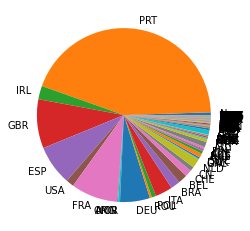

In [4]:
# 看哪一個country有dominate的現象
# 'PRT'有這個現象
piechart(train_d['country'])

{'BB': 71893, 'HB': 10933, 'FB': 714, 'SC': 6952, 'Undefined': 1039}


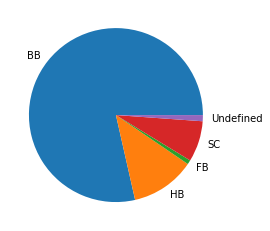

In [83]:
#meal
piechart(train_d['meal'])

{'Direct': 9571, 'Offline TA/TO': 19854, 'Online TA': 40371, 'Corporate': 4516, 'Groups': 16464, 'Complementary': 605, 'Undefined': 2, 'Aviation': 148}


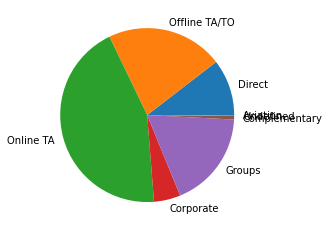

In [84]:
#market segment
piechart(train_d['market_segment'])

0.8562891260884291
{'C': 1702, 'A': 57127, 'E': 5739, 'B': 1933, 'D': 19316, 'I': 298, 'F': 2813, 'G': 1840, 'H': 523, 'L': 1, 'K': 233, 'P': 6}


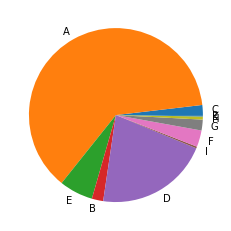

In [85]:
#檢測有多少reserved與assigned room type一樣
#比例差不多
print((train_d['reserved_room_type'] == train_d['assigned_room_type']).sum() / train_d.shape[0])

piechart(train_d['assigned_room_type'])

13217
{'Nan': 13217, 6.0: 2644, 9.0: 22444, 8.0: 1150, 156.0: 190, 115.0: 223, 253.0: 87, 240.0: 10367, 15.0: 340, 5.0: 274, 241.0: 1157, 250.0: 2026, 304.0: 1, 303.0: 2, 242.0: 572, 243.0: 376, 1.0: 7102, 69.0: 74, 134.0: 476, 175.0: 142, 11.0: 371, 3.0: 1185, 105.0: 14, 40.0: 531, 13.0: 82, 142.0: 137, 196.0: 247, 147.0: 126, 306.0: 22, 149.0: 28, 7.0: 2724, 184.0: 40, 128.0: 23, 96.0: 454, 127.0: 34, 2.0: 139, 143.0: 114, 95.0: 126, 146.0: 101, 27.0: 359, 26.0: 395, 177.0: 256, 244.0: 4, 22.0: 336, 14.0: 2398, 17.0: 241, 261.0: 32, 300.0: 1, 167.0: 3, 171.0: 531, 305.0: 45, 19.0: 808, 67.0: 127, 152.0: 141, 10.0: 194, 36.0: 100, 28.0: 1360, 104.0: 48, 71.0: 71, 42.0: 100, 110.0: 12, 29.0: 633, 258.0: 3, 20.0: 357, 181.0: 33, 66.0: 44, 45.0: 28, 114.0: 1, 34.0: 264, 37.0: 1044, 57.0: 18, 16.0: 186, 61.0: 2, 88.0: 18, 24.0: 22, 39.0: 85, 21.0: 779, 251.0: 144, 4.0: 47, 275.0: 7, 41.0: 75, 50.0: 20, 301.0: 1, 30.0: 398, 68.0: 211, 70.0: 1, 252.0: 29, 72.0: 6, 75.0: 61, 81.0: 6, 245.0: 

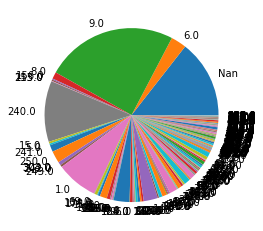

In [107]:
#agent
print(pd.isna(train_d['agent']).sum()) #總共13217筆為Nan
piechart(train_d['agent'])

{'Nan': 85917, 270.0: 39, 204.0: 33, 110.0: 52, 135.0: 45, 154.0: 114, 113.0: 33, 42.0: 5, 77.0: 1, 178.0: 23, 240.0: 3, 20.0: 42, 83.0: 9, 9.0: 36, 40.0: 797, 46.0: 26, 45.0: 202, 38.0: 51, 103.0: 12, 144.0: 27, 108.0: 8, 47.0: 67, 49.0: 5, 307.0: 18, 268.0: 14, 48.0: 5, 51.0: 97, 62.0: 42, 292.0: 12, 86.0: 30, 67.0: 267, 68.0: 46, 82.0: 13, 200.0: 3, 195.0: 28, 59.0: 5, 76.0: 1, 72.0: 27, 223.0: 655, 84.0: 3, 246.0: 3, 312.0: 3, 65.0: 1, 91.0: 36, 81.0: 22, 318.0: 1, 96.0: 1, 28.0: 5, 287.0: 5, 93.0: 3, 174.0: 134, 94.0: 80, 319.0: 3, 274.0: 14, 100.0: 1, 31.0: 17, 286.0: 21, 159.0: 6, 281.0: 131, 115.0: 3, 116.0: 5, 101.0: 1, 92.0: 13, 105.0: 8, 120.0: 14, 323.0: 8, 317.0: 9, 329.0: 6, 325.0: 2, 118.0: 7, 43.0: 8, 88.0: 20, 331.0: 56, 11.0: 1, 37.0: 10, 324.0: 9, 53.0: 8, 122.0: 18, 278.0: 2, 12.0: 13, 137.0: 4, 297.0: 7, 139.0: 3, 80.0: 1, 16.0: 4, 142.0: 1, 337.0: 17, 127.0: 15, 338.0: 10, 130.0: 6, 342.0: 48, 148.0: 27, 343.0: 29, 346.0: 14, 347.0: 1, 107.0: 9, 140.0: 1, 349.0: 2

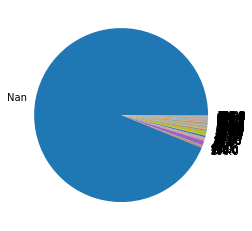

In [108]:
#company
piechart(train_d['company'])

{'Nan': 0, 'Transient': 66236, 'Transient-Party': 21386, 'Contract': 3463, 'Group': 446}


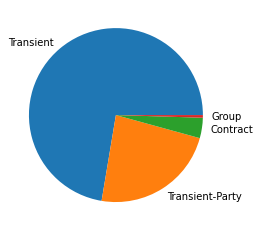

In [24]:
piechart(train_d['customer_type'])

{'Nan': 0, 0: 85572, 1: 5934, 2: 22, 3: 1, 8: 2}


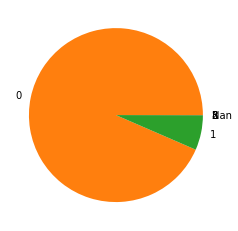

In [6]:
piechart(train_d['required_car_parking_spaces'])

{'Nan': 0, 0: 56351, 3: 1645, 2: 9287, 1: 24054, 4: 173, 5: 21}


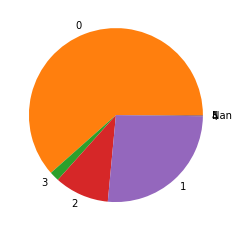

In [7]:
piechart(train_d['total_of_special_requests'])

{'Nan': 0, 'Check-Out': 58771, 'Canceled': 31741, 'No-Show': 1019}


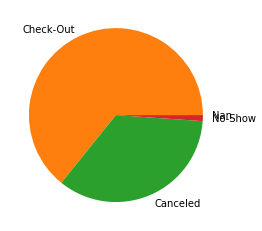

{'Nan': 0, 0: 58771, 1: 32760}


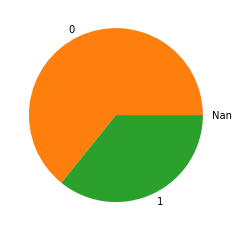

In [10]:
#canceld的兩者吻合, 用is_canceled即可
piechart(train_d['reservation_status'])
piechart(train_d['is_canceled'])

{'Nan': 0, 0: 6092, 2: 26624, 4: 6946, 5: 7795, 1: 24036, 10: 777, 3: 16432, 11: 47, 8: 455, 6: 1101, 7: 741, 15: 79, 9: 162, 13: 23, 12: 35, 42: 1, 20: 41, 33: 1, 21: 13, 16: 15, 14: 33, 19: 43, 24: 3, 25: 6, 22: 7, 30: 5, 18: 6, 17: 4, 35: 1, 50: 1, 34: 1, 41: 1, 40: 2, 32: 1, 26: 1}


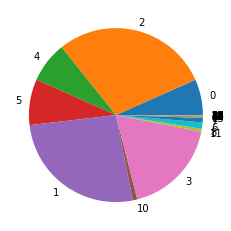

{'Nan': 0, 0: 41153, 1: 23607, 2: 24174, 4: 1357, 3: 918, 6: 142, 5: 71, 18: 1, 9: 10, 7: 19, 13: 3, 8: 58, 10: 7, 12: 5, 14: 2, 19: 1, 16: 3}


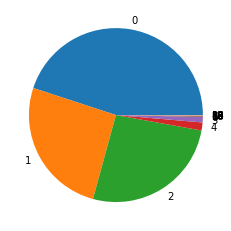

The number of both stay: 44942


In [25]:
#確認stays in week nights與weekend的關係
#滿多人同時住平日 + 週末，比較難以分開計算週末的調整幅度
piechart(train_d['stays_in_week_nights'])
piechart(train_d['stays_in_weekend_nights'])

both_stay = 0
k = -1
for i in range(train_d.shape[0]):
    if train_d['stays_in_week_nights'][i] != 0 and train_d['stays_in_weekend_nights'][i] != 0:
        k = i
        both_stay += 1
        
print("The number of both stay: {}".format(both_stay))

{'Nan': 0, 'Direct': 11411, 'TA/TO': 74226, 'Corporate': 5738, 'Undefined': 5, 'GDS': 151}


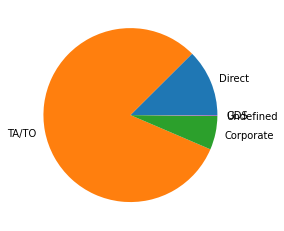

In [18]:
piechart(train_d['distribution_channel'])

In [88]:
pd.unique(train_d['deposit_type'])

array(['No Deposit', 'Non Refund', 'Refundable'], dtype=object)